Task 1
Generalize all the preprocessing tasks into one single function that can be use in the Vectorizer (passing boolean to make sure that you can activate or deactivate on preprocessing step)

Task 2
Work and research on Hashing Vectorizer. What advantage and disadvantage it gives. Implement it for you project (use TFidf for the rest)

Research
Research and create a presentation of the model you have been assign to work on.

Task 4
Implement your research model in order to predict industries on your dataset

Task 5
Learn and implement techniques to evaluate your model Use sklearn

Task 6 (Optional)
Create a WordCloud for each cluster predicted by your model



In [ ]:
import pandas as pd
import regex as re
import unicodedata
import string
import numpy as np
import spacy
from time import time
from tqdm import tqdm
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import nltk
from sklearn.metrics import silhouette_score

In [ ]:
df = pd.read_csv('employer_raw_data_group_1.csv')

In [ ]:
!python -m spacy download en_core_web_sm >> /dev/null
!python -m nltk.downloader stopwords >> /dev/null

2021-10-27 18:11:02.074768: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-27 18:11:02.074988: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
/usr/local/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
PUNCT_TO_REMOVE = string.punctuation
SNOWBALL_STEMMER = nltk.stem.SnowballStemmer("english")
NLP = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
STOP_WORDS = nltk.corpus.stopwords.words("english")

In [ ]:
def get_preprocessing_function(
    use_phone_number: bool = True,
    use_emoji: bool = True,
    use_lower: bool = True,
    use_alpha: bool = True,
    use_email: bool = True,
    use_normalize: bool = True,
    use_url: bool = True,
    use_rand_digits: bool = True,
    use_punctuation: bool = True,
    use_stopwords: bool = True,
    use_lemmatizer: bool = True,
    use_stemming: bool = False
):
    alpha_regex = re.compile(r"[^a-z]+")
    def alpha(text: str):
        return alpha_regex.sub(r" ", text) if use_alpha else text

    phone_number_pattern = re.compile(r'\+?([0-9]{1,2})?\s?-?\s?\(?\d{3}\)?\s?-?\s?\d{3,4}\s?-?\s?\d{4}')
    def remove_phone_number(text: str):
        return phone_number_pattern.sub("", text) if use_phone_number else text

    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0000231B-\U0001F566"  # time
            "]+", flags=re.UNICODE)
    def remove_emoji(text: str):
        return emoji_pattern.sub(r'', text) if use_emoji else text
    
    email_address_pattern = re.compile(r"[\w.-]+@[\w.]+\.[a-zA-Z]{2,4}")
    def remove_email_address(text: str):
        
        return email_address_pattern.sub(r'', text) if use_email else text
    
    url_pattern = re.compile(r'(https?):\/\/(\w{2,3}\.[A-Za-z-]{2,256}\.[a-z]{2,6})([-a-zA-Z-0-9@:%_\+.~#?&//=]*)')
    def remove_urls(text: str):
        return url_pattern.sub(r'', text) if use_url else text
    
    def remove_punctuation(text: str):
        return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE)) if use_punctuation else text
    
    def all_lower_case(text: str):
        return text.lower() if use_lower else text
    
    def remove_random_digits(text: str):
        return ''.join([i for i in text if not i.isdigit()]) if use_rand_digits else text

    def normalize_text(text: str):
        return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore') if use_normalize else text
    
    def clean_stopwords(text: str):
        temp = text.split(" ")
        return " ".join([token for token in temp if token not in STOP_WORDS]) if use_stopwords else text

    def apply_spacy_lemm(text: str):
        temp = NLP(text)
        return " ".join([word.lemma_ for word in temp]) if use_lemmatizer else text
    
    def apply_snowball_stemmer(text: str):
        temp = text.split(" ")
        return ' '.join([SNOWBALL_STEMMER.stem(word) for word in temp]) if use_stemming else text

    def preprocess(text: str):
        funcs = [remove_emoji, 
                remove_phone_number, 
                all_lower_case, 
                remove_email_address, 
                normalize_text,
                remove_urls, 
                remove_random_digits, 
                remove_punctuation,
                clean_stopwords,
                alpha,
                apply_spacy_lemm,
                apply_snowball_stemmer]
        for func in funcs:
            text = func(text)
        
        return text
        
    return preprocess

In [ ]:
preprocess = get_preprocessing_function(
    use_phone_number = True,
    use_emoji = True,
    use_lower = True,
    use_alpha = True,
    use_email = True,
    use_normalize = True,
    use_url = True,
    use_rand_digits = True,
    use_punctuation = True,
    use_stopwords = True,
    use_lemmatizer = True,
    use_stemming = False
)

In [ ]:
df['description'] = df['description'].fillna(".")
df['description'] = df['description'].astype(str)
clean_descriptions = []
descriptions = df["description"].values
for desc in tqdm(descriptions):
    clean_descriptions.append(preprocess(desc))
df['clean_description'] = clean_descriptions


  2%|▏         | 396/20000 [00:24<20:04, 16.27it/s]


KeyboardInterrupt: 

In [ ]:
df.to_csv("employer_raw_data_group_1.csv")

In [ ]:
df = pd.read_csv("employer_raw_data_group_1.csv")

In [ ]:
# Hashing Vectorizer

NGRAM = (1, 1)
vectorizer = HashingVectorizer(
    input = 'content',
    preprocessor=lambda x: x,
    tokenizer=lambda s: s.split(),
    stop_words=STOP_WORDS,
    ngram_range=NGRAM,
    alternate_sign = False
)

In [ ]:
vector = vectorizer.fit_transform(df['clean_description'].values.astype(str))

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


The hashing vectorizer is very efficient for large data sets since it does not store the vocabulary. By not having to store the vocabulary, the resulting HashingVectorizer object when saved, would be much smaller and thus faster to load back into memory when needed. 

A disadvantage with this vectorizer is that it is not possible to retrieve those tokens when needed from just the column positions. Thus we cannot get the keywords 

In [ ]:
# Combining industry data with raw data
df = pd.read_csv('employer_raw_data_group_1.csv')
df2 = pd.read_csv("../assets/industry_data.csv")

data = [df, df2]
combined_data = pd.concat(data)

In [ ]:
combined_data.to_csv('combined_data.csv')

K means: 
the objective of K-means is simple: group similar data points together and discover underlying patterns. To achieve this objective, K-means looks for a fixed number (k) of clusters in a dataset

define a target number k, which refers to the number of centroids you need in the dataset. A centroid is the imaginary or real location representing the center of the cluster.

Every data point is allocated to each of the clusters through reducing the in-cluster sum of squares.
In other words, the K-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible.


In [ ]:
#========= K-MEANS ==========
NGRAM = (1,1)
MIN_DF = .02
MAX_DF = .9
MAX_FEATURES = 5000


idf_vec = TfidfVectorizer(
    preprocessor=lambda x: x,
    ngram_range=NGRAM,
    tokenizer=lambda s: s.split(),
    stop_words=STOP_WORDS,
    min_df=MIN_DF,
    max_df=MAX_DF,
    max_features=MAX_FEATURES,
    use_idf=True,
    smooth_idf=True
)

In [ ]:
idf_vec = idf_vec.fit(combined_data['clean_description'].values.astype(str))

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [ ]:
len(idf_vec.idf_)

2268

In [ ]:
# Vectorizing descriptions

vector = idf_vec.fit_transform(combined_data['clean_description'].values.astype(str))
#vector.todense()

In [ ]:
kmeans = KMeans(n_clusters=28, init='k-means++', max_iter=300, n_init=10).fit(vector)

In [ ]:
predictions = kmeans.predict(vector)

In [ ]:
len(predictions)

20013

In [ ]:
combined_data['clusters'] = predictions

In [ ]:
combined_data.to_csv('combined_data.csv')


In [ ]:
silhouette_score(vector, vec_pred)

0.03388860846705652

In [ ]:
""" 
Silhouette Score:
    - Calculates how far each clusters are from each other
    - The farther the clusters are from each other, the better
    - The closer the Silhouette Score is to 1 -> clusters are farther from each other -> best number of clusters

Problem: The notebook struggles with computing the Silhouette scores 
"""
k_rng = range(1,15)
kmeans_per_k = [KMeans(n_clusters=k).fit(vector) for k in tqdm(k_rng)]


100%|██████████| 14/14 [05:11<00:00, 22.22s/it]


In [ ]:
silhouette_scores = [silhouette_score(vector, model.labels_) for model in kmeans_per_k[1:]]

silhouette_scores

NameError: name 'kmeans_per_k' is not defined

In [ ]:
'''
ELBOW TECHNIQUE
    - Hard to find the right numbers of clusters because of the number of features and the the descriptions
    - Computes the Sum of Squared Errors in each cluster 
        - For each cluster is computes the distance of each data point to the cluster centroid
        - Then squares in to avoid negative numbers
        - Then Sums up all those distances together
    - After finding the SSE for each cluster, you add all those up to get the total SSE for the whole dataset
    - The premise is that as you increase the cluster, the closer the SSE is to 0
    - After plotting the SSE for a range of k-clusters, you pick the K where it looks like an elbow which represents the 
        optimal number of clusters

Problem: Because of the dimensions of our vectors, the number features in the vocabulary, and noise of the data,
    the SSE scores was a gradual change and had no clear "elbow"
'''

k_rng = range(1,31)
sse = []
for k in k_rng:
    km = KMeans(n_clusters = k,max_iter=300)
    km.fit(vector)
    sse.append(km.inertia_)

KeyboardInterrupt: 

In [ ]:

nsse = [float(i)/max(sse) for i in sse]

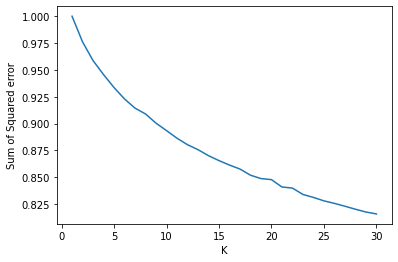

In [ ]:
plt.xlabel('K')
plt.ylabel('Sum of Squared error')
plt.plot(k_rng, nsse)

## CONCLUSION: 
K-means is not the optimal model for text processing
- Too much noise from each description
- Too many features to try and compare and determine the right cluster
- In our case we had 2268 features (2268 dimensions to compare)
    * If we lowered the number of features, the less accurate the model will be


- Business= 9
- consumer = 11
- agriculture = 11
- education = 18
- energy and utilities = 13
- financial services = 6
- government = 11
- health = 27
- manufacturing = 9
- media and entertainment = 9
- non profit = 11
- real estate = 6 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6697285f-e1ca-4fc0-a227-983fc59e4276' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>